## WASP-189

Example of using Multivisit to measure eclipse depths in multiple data sets. 

See `help(MultiVisit)` for more information on the use of this feature.

Using the following datasets analysed by [Lendl et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...643A..94L/abstract)

- CH_PR100041_TG000201_V0102
- CH_PR100041_TG000202_V0102
- CH_PR100041_TG000203_V0102
- CH_PR100041_TG000204_V0102


In [1]:
%pylab inline
from pycheops import MultiVisit
from pycheops import Dataset
from uncertainties import ufloat
from pycheops.constants import c, au

Populating the interactive namespace from numpy and matplotlib


### Planet properties
The parameters `D`, `W` and `b` that specify the geometry of the star-planet system cannot be determined from the eclipse so we have to give their values to the fitting routine. Here we used the values and errors from Lendl et al. (2020). Each paramater is defined as a `ufloat` so that the uncertainty on these values is accounted for in the analysis.


In [2]:
# Transit paramaters from  Lendl et al., 2020
BJD_0 = 2458926.541696  
P = 2.7240330
T14 = ufloat(4.336, 0.0056)   # In hours
b = ufloat(0.478,0.01)
k = ufloat(0.07045, 0.00014)
D = k**2
W = T14/24/P
a_c = 0.05053 * au/c / 86400
print(f'Light travel time correction = {a_c*86400:0.1f} s')

Light travel time correction = 25.2 s


#### Download datasets from DACE

In [3]:
file_keys = [f'CH_PR100041_TG00020{i}_V0102' for i in range(1,5)]
Datasets=[]
for file_key in file_keys:
    d = Dataset(file_key,verbose=False, metadata=False)
    Datasets.append(d)
    _ = d.get_lightcurve('DEFAULT',verbose=False,decontaminate=False)
    t_,f_,e_ = d.clip_outliers(verbose=False)
    t_mid =  d.bjd_ref+np.median(t_)
    print(f'{file_key}, n_obs={len(t_)}, BJD_REF = {d.bjd_ref}')


CH_PR100041_TG000201_V0102, n_obs=736, BJD_REF = 2458927
CH_PR100041_TG000202_V0102, n_obs=793, BJD_REF = 2458935
CH_PR100041_TG000203_V0102, n_obs=814, BJD_REF = 2458938
CH_PR100041_TG000204_V0102, n_obs=934, BJD_REF = 2458946


### Fit with decorrelation

Selection of decorrelation parameters and other details of these fits are quite arbitary here. In reality, a much more careful analysis similar to the one shown in KELT11b-tutorial would be needed.

These decorrelation parameters selected and saved in the last fit to each the individual datasets are used in Multivisit.  


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 736
    # variables        = 11
    chi-square         = 849.699826
    reduced chi-square = 1.17199976
    Akaike info crit   = -11583.9915
    Bayesian info crit = -11533.3779
    RMS residual       = 90.7 ppm
[[Variables]]
    T_0:        -0.458304 (fixed)
    P:           2.724033 (fixed)
    D:           0.00496314 +/- 2.1311e-05 (0.43%) (init = 0.004963202)
    W:           0.06632749 +/- 9.2456e-05 (0.14%) (init = 0.06632323)
    b:           0.47792240 +/- 0.01079999 (2.26%) (init = 0.478)
    L:           8.6833e-05 +/- 1.0741e-05 (12.37%) (init = 0.0002)
    f_c:         0 (fixed)
    f_s:         0 (fixed)
    l_3:         0 (fixed)
    c:           0.99994823 +/- 1.7306e-05 (0.00%) (init = 1)
    a_c:         0 (fixed)
    dfdt:       -3.4933e-04 +/- 2.0727e-05 (5.93%) (init = 0)
    d2fdt2:      0.00167211 +/- 2.1040e-04 (12.58%) (init = 0)
    dfdsinphi:  -2.9117e-05 +

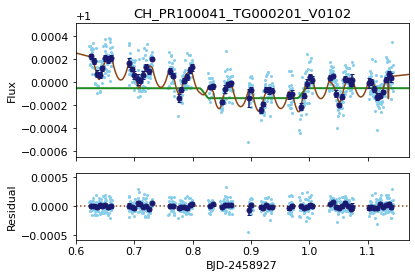

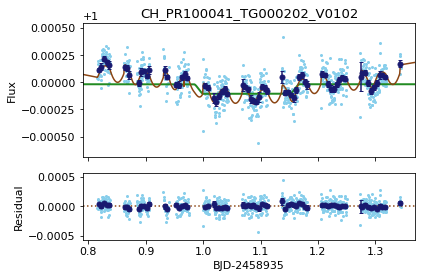

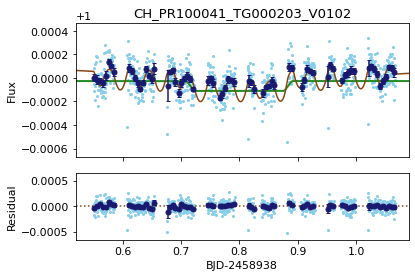

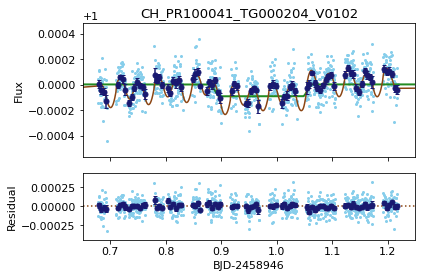

In [4]:
lmfits = []
dfdbg = [0, (-1e3,1e3), 0, ufloat(0, 1e3)]
for i,d in enumerate(Datasets):
    T_0 = floor((d.bjd_ref-BJD_0)/P)*P + BJD_0 - d.bjd_ref
    if dfdbg[i] == 0:
        d.lmfit_eclipse(T_0 = T_0,
                    P = P, 
                    dfdt=(-0.1,0.1),
                    d2fdt2=(-0.1,0.1),
                    L=(1e-6,2e-4,1e-3),
                    W =W, D=D, b=b,
                    dfdsinphi=(-1,1),dfdcosphi=(-1,1),
                    dfdsin2phi=(-1,1),dfdcos2phi=(-1,1) )
    else:
        d.lmfit_eclipse(T_0 = T_0,
                    P = P, 
                    dfdt=(-0.1,0.1),
                    d2fdt2=(-0.1,0.1),
                    L=(1e-6,2e-4,1e-3),
                    W =W, D=D, b=b,
                    dfdbg=dfdbg[i], 
                    dfdsinphi=(-1,1),dfdcosphi=(-1,1),
                    dfdsin2phi=(-1,1),dfdcos2phi=(-1,1) )
    lmfits.append(d.lmfit)
    f = d.plot_lmfit(title=d.file_key)
    print(d.lmfit_report())
    print('\n-------\n')
    d.save()  # Saves the results as a .dataset file for use in Multivisit 

#### Create a Multivisit object using saved datasets in the working directory
The option `id_kws={'dace':False}` can be used to look for target information from SWEET-Cat if the target is not listed on the tables on DACE. 

We can also set our own values for the star properties - here we use the values from Lendl et al.

In [5]:
M = MultiVisit('WASP-189', id_kws={'dace':False, 
                                   'teff':ufloat(8000,80), 
                                   'logg':ufloat(3.9,0.2),
                                   'metal':ufloat(0.29,0.13)})

Identifier : WASP-189
Coordinates: 15:02:44.87 -03:01:53.0
T_eff :  8000 +/-  80 K   [User]
log g :  3.90 +/- 0.20    [User]
[M/H] : +0.29 +/- 0.13    [User]
log rho : -0.89 +/- 0.33  (solar units)
h_1 : 0.787 +/- 0.100     [ATLAS]
h_2 : 0.529 +/- 0.100     [ATLAS]


 N  file_key                   Aperture last_ GP Glint Scale pipe_ver extra
 --------------------------------------------------------------------------
  1 CH_PR100041_TG000201_V0102 DEFAULT  lmfit No  No    n/a    cn03-20200703T111359     0
  2 CH_PR100041_TG000202_V0102 DEFAULT  lmfit No  No    True   cn03-20200703T111359     0
  3 CH_PR100041_TG000203_V0102 DEFAULT  lmfit No  No    n/a    cn03-20200703T111359     0
  4 CH_PR100041_TG000204_V0102 DEFAULT  lmfit No  No    True   cn03-20200703T111359     0


#### fit_eclipse with eclipse depth variation (edv)

The option `edv=True` is used so that different planet/star flux ratios, $L_1, L_2, \dots$ are used for each dataset. A Gaussian prior with a mean value  `L`=85 ppm and standard deviation `ebv_prior`=50 ppm is imposed on  $L_1, L_2, \dots$.

The parameter `log_sigma_w` specifies additional uncorrelated white noise per data-point $\log \sigma_w$.


**N.B.** the fit *automagically* includes the following model to account for trends in the data correlated with roll angle: $$\sum_{j=1}^n \alpha_j\sin(j\cdot\Omega t) + \beta_j\cos(j\cdot\Omega t),$$
where, $\Omega$ is the angular rotation frequency of the spacecraft. The free parameters $\alpha_j$ and $\beta_j$ are never calculated explicitly. Instead, they are implicitly accounted for in the calculation of the likelihood using the trick explained by Rodrigo et al. ([2017RNAAS...1....7L](https://ui.adsabs.harvard.edu/abs/2017RNAAS...1....7L/abstract)). The number of terms in this model ($n=3$ by default) can be set using the parameter `nroll`. Additional decorrelation parameters can be selected using the `extra_priors` keyword.

In [6]:
# Time of transit closest to mid-point of datasets
T_0 = M.tzero(BJD_0, P)
result = M.fit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, a_c=a_c, 
                    L = 85e-6, edv=True, edv_prior=50e-6, nroll=2,
                    log_sigma_w=ufloat(-10,5), 
                       extra_priors = {'dfdbg_02':ufloat(0,500)},
                    burn=512, steps=256, nwalkers=128) 

Running burn-in ..


100%|██████████| 512/512 [04:04<00:00,  2.10it/s]

Running sampler ..



100%|██████████| 256/256 [02:43<00:00,  1.57it/s]


#### Plot the fit

The green line is the eclipse light curve with no instrumental effects or trends. The brown line is the fit to the data. You can use the keywords `add_gaps` and `gap_tol` to control whether/how this fit is plotted with gaps.  

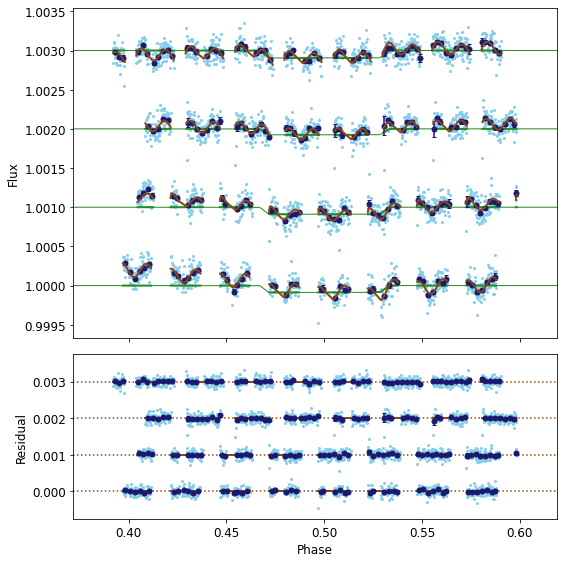

In [7]:
M.plot_fit(binwidth=0.0025, data_offset=0.001, res_offset=0.001);

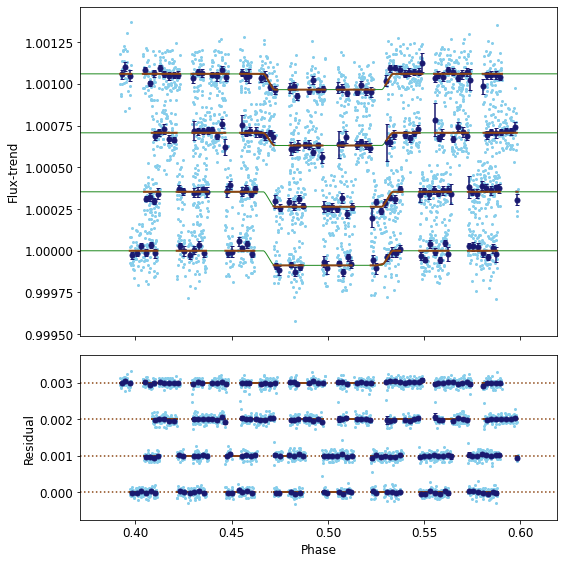

In [8]:
M.plot_fit(binwidth=0.0025,detrend=True);

#### Trail plot
It is good practice to check that the emcee sampler has converged by inspecting a plot of the parameter values v. step number for all the walkers. This can be done using the `trail_plot` command. The trails should look like noise,  i.e., no trends in the mean or variance of the walkers v. step number.

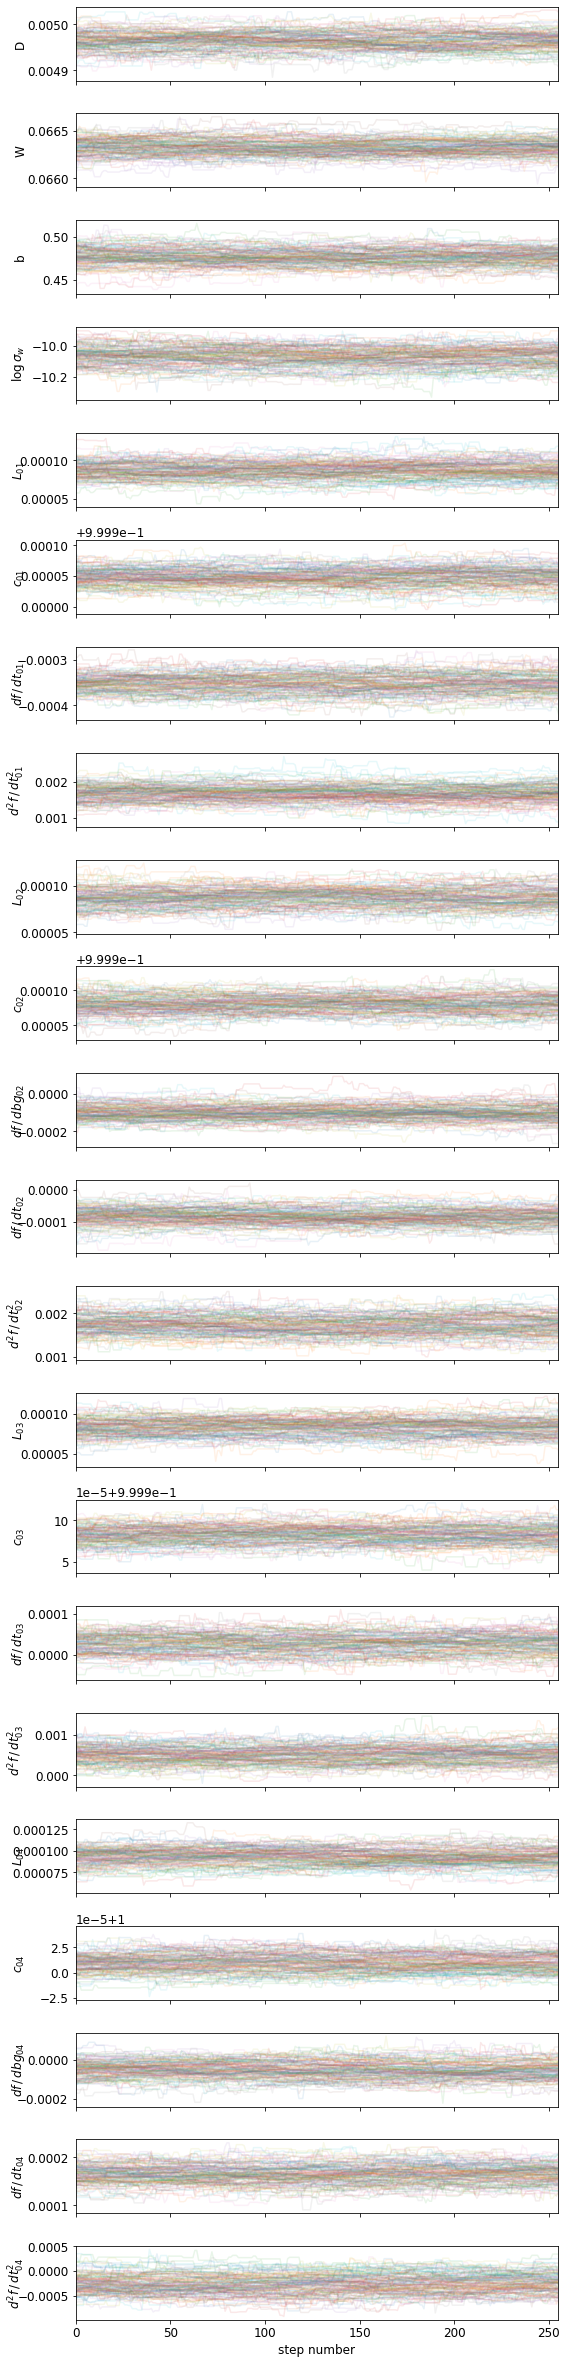

In [9]:
M.trail_plot(plotkeys='all');

In [10]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 113587
    # data points      = 3277
    # variables        = 22
    chi-square         = 4087.81713
    reduced chi-square = 1.25585780
    Akaike info crit   = -51141.8613
    Bayesian info crit = -51007.7783
    RMS residual       = 94.7 ppm
[[Variables]]
    D:            0.00496437 +/- 2.0015e-05 (0.40%) (init = 0.004963202)
    W:            0.06632241 +/- 8.5040e-05 (0.13%) (init = 0.06632323)
    b:            0.47611392 +/- 0.00997143 (2.09%) (init = 0.478)
    P:            2.724033 (fixed)
    T_0:          1937.438 (fixed)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    l_3:          0 (fixed)
    L:            8.5e-05 (fixed)
    a_c:          0.0002918369 (fixed)
    k:            0.07045827 == 'sqrt(D)'
    aR:           4.60144231 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:         0.99463251 == 'sqrt(1 - (b/aR)**2)'
    logrho:      -0.75405609 == 'log10(4.3275e-4*((1+k)**2-b**2)**1.5/W*

#### Parameter correlation (corner) plot
 Use `plotkeys='all'` to show all the free parameters in this corner plot. Here we are using some neat python syntax to generate a list of parameters incuding all the ttv values.

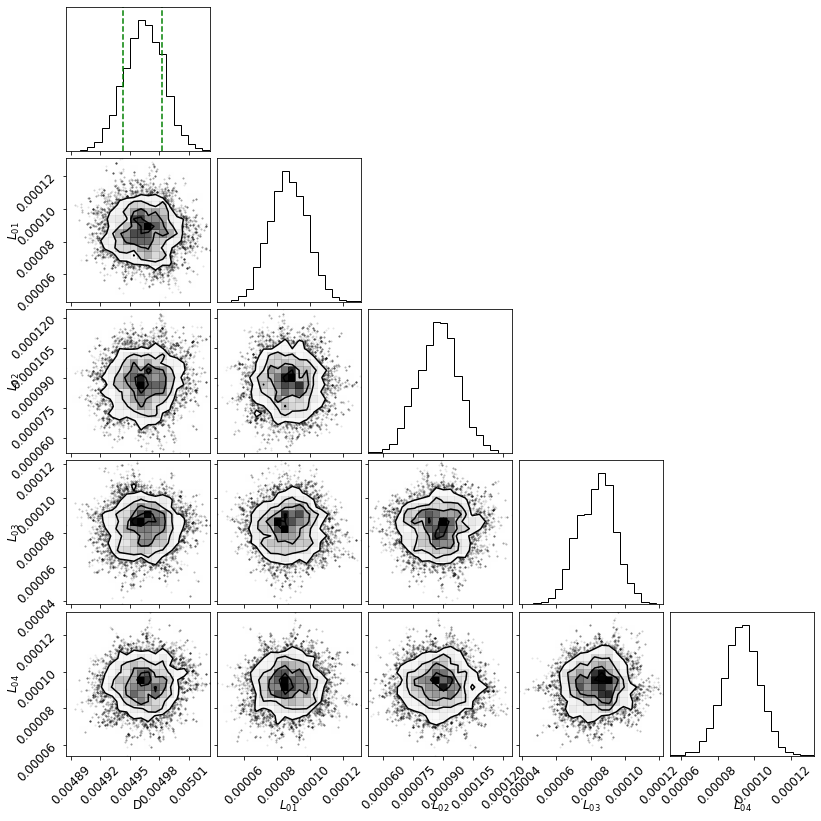

In [11]:
pk = ['D'] + [f'L_{k+1:02d}' for k in range(len(M.datasets))] 
M.corner_plot(plotkeys=pk,show_ticklabels=True);

#### Plot of eclipse depth v. time.
The $\pm$1-$\sigma$ range from Lendl et al. is shown for comparison. 


If you are fitting transits with transit-time variations (ttv=True) then you can use `M.ttv_plot()` to produce a nice O-C diagram.

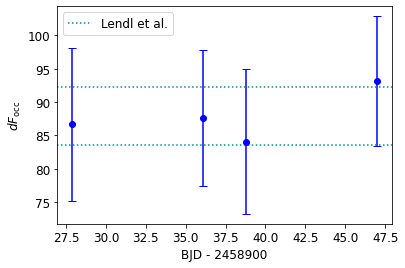

In [12]:
fig,ax = subplots()
for j in range(4):
    t = M.datasets[j].lc['time'].mean() - 1900
    l = result.params[f'L_{j+1:02d}'].value*1e6
    lerr = result.params[f'L_{j+1:02d}'].stderr*1e6
    ax.errorbar(t,l,yerr=lerr,fmt='bo',capsize=4)
axhline(87.9-4.3,c='darkcyan',ls=':',label='Lendl et al.')
axhline(87.9+4.3,c='darkcyan',ls=':')
ax.set_xlabel('BJD - 2458900')
ax.set_ylabel(r'$dF_{\rm occ}$')
ax.legend();

#### Write the data to tables with a ReadMe file suitable for upload to CDS

In [13]:
from os.path import join,abspath,dirname
from pycheops import __file__ as pycheops_file
src = join(dirname(abspath(pycheops_file)),'examples','Notebooks')
with open(join(src,'wasp189_abstract.txt')) as fh: abstract = fh.read()
with open(join(src,'wasp189_authors.txt')) as fh: authors = fh.read()
with open(join(src,'wasp189_keywords.txt')) as fh: keywords = fh.read()
M.cds_data_export(title='CHEOPS WASP-189 b transit light curve', 
                  author='Lendl M.', 
                  authors=authors,
                  abstract=abstract, 
                  keywords=keywords, 
                  bibcode='2020A&A...643A..94L',
                  acknowledgements='Monika Lendl, monika.lendl(at)unige.ch')

&copy; Pierre Maxted, Keele University, 2023